# Beating the Market with AI

### Initial Project Setup

In [22]:
# Initial library and module imports
import numpy as np
import talib as ta
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

# Scikit-learn model imports
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

# Disable false positive error message
pd.options.mode.chained_assignment = None

In [23]:
# Initial file uploads for Google Colab
# from google.colab import files
# uploaded = files.upload()

### Data Import & Preparation

In [24]:
# Read Apple csv into dataframe - Colab
# aapl_df = pd.read_csv(
#     Path("./AAPL.csv"),
#     index_col="Date",
#     parse_dates=True,
#     infer_datetime_format=True
# )

# Read Apple csv into dataframe - Non-Colab
aapl_df = pd.read_csv(
    Path("./data/AAPL.csv"),
    index_col="Date",
    parse_dates=True,
    infer_datetime_format=True
)

In [25]:
# Read Microsoft csv into dataframe - Colab
# msft_df = pd.read_csv(
#     Path("./MSFT.csv"),
#     index_col="Date",
#     parse_dates=True,
#     infer_datetime_format=True
# )

# Read Microsoft csv into dataframe - Non-Colab
msft_df = pd.read_csv(
    Path("./data/MSFT.csv"),
    index_col="Date",
    parse_dates=True,
    infer_datetime_format=True
)

In [26]:
# Verify dataframe
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


In [27]:
# Verify dataframe
msft_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


### Stock Trading Algorithm

In [28]:
# Create a new dataframe to hold the closing prices and future indicator and signal values. Starting values set to ~10 years of data - Apple
aapl_technical_df = aapl_df.loc["2012-01-01":, ["Close"]]

In [29]:
# Create a new dataframe to hold the closing prices and future indicator and signal values. Starting values set to ~10 years of data - Microsoft
msft_technical_df = msft_df.loc["2012-01-01":, ["Close"]]

In [30]:
# Add daily return values to the dataframes and drop NaN values - Apple
aapl_technical_df["Actual Returns"] = aapl_technical_df["Close"].pct_change()

aapl_technical_df = aapl_technical_df.dropna()

In [31]:
# Add daily return values to the dataframes and drop NaN values - Microsoft
msft_technical_df["Actual Returns"] = msft_technical_df["Close"].pct_change()

msft_technical_df = msft_technical_df.dropna()

In [32]:
# Create MACD, RSI, and multiple EMA indicators - Apple
ema7 = ta.EMA(aapl_technical_df["Close"], timeperiod = 7)

ema14 = ta.EMA(aapl_technical_df["Close"], timeperiod = 14)

ema28 = ta.EMA(aapl_technical_df["Close"], timeperiod = 28)

real = ta.RSI(aapl_technical_df["Close"], timeperiod = 14)

macd, macdsignal, macdhist = ta.MACD(aapl_technical_df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

# Create a dataframe containing the indicator data
df = pd.concat({
    "7 Day EMA":ema7,
    "14 Day EMA":ema14,
    "28 Day EMA":ema28,
    "RSI":real,
    "MACD":macd,
    "MACD Signal":macdsignal,
    "MACD Hist":macdhist
}, axis=1)

# Join the original dataframe and the indicators dataframe
aapl_technical_df = aapl_technical_df.join(df)

# Drop NaN values from datframe
aapl_technical_df = aapl_technical_df.dropna()

In [33]:
# Create MACD, RSI, and multiple EMA indicators - Microsoft
ema7 = ta.EMA(msft_technical_df["Close"], timeperiod = 7)

ema14 = ta.EMA(msft_technical_df["Close"], timeperiod = 14)

ema28 = ta.EMA(msft_technical_df["Close"], timeperiod = 28)

real = ta.RSI(msft_technical_df["Close"], timeperiod=14)

macd, macdsignal, macdhist = ta.MACD(msft_technical_df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

# Create a dataframe containing the indicator data
df = pd.concat({
    "7 Day EMA":ema7,
    "14 Day EMA":ema14,
    "28 Day EMA":ema28,
    "RSI":real,
    "MACD":macd,
    "MACD Signal":macdsignal,
    "MACD Hist":macdhist
}, axis=1)

# Join the original dataframe and the indicators dataframe
msft_technical_df = msft_technical_df.join(df)

# Drop NaN values from datframe
msft_technical_df = msft_technical_df.dropna()

In [34]:
# Create signals column to store buy and sell signals - Apple
aapl_technical_df["Signals"] = 0.0

In [35]:
# Create signals column to store buy and sell signals - Microsoft
msft_technical_df["Signals"] = 0.0

In [36]:
# Create signals algorithm to identify when 7 Day EMA is above the 14 & 28 day to generate a buy signal and when 7 Day EMA is below 14 & 28 day to generate a sell signal - Apple
aapl_technical_df.loc[
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["14 Day EMA"])
    &
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["28 Day EMA"]), 
    "Signals"
] = 1

aapl_technical_df.loc[
    (aapl_technical_df["7 Day EMA"] < aapl_technical_df["14 Day EMA"])
    &
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["28 Day EMA"]), 
    "Signals"
] = -1

In [37]:
# Create signals algorithm to identify when 7 Day EMA is above the 14 & 28 day to generate a buy signal and when 7 Day EMA is below 14 & 28 day to generate a sell signal - Microsoft
msft_technical_df.loc[
    (msft_technical_df["7 Day EMA"] > msft_technical_df["14 Day EMA"]) 
    & 
    (msft_technical_df["7 Day EMA"] > msft_technical_df["28 Day EMA"]), 
    "Signals"
] = 1

msft_technical_df.loc[
    (msft_technical_df["7 Day EMA"] < msft_technical_df["14 Day EMA"]) 
    & 
    (msft_technical_df["7 Day EMA"] > msft_technical_df["28 Day EMA"]), 
    "Signals"
] = -1

In [38]:
# Create strategy returns column - Apple
aapl_technical_df["Strategy Returns"] = aapl_technical_df["Actual Returns"] * aapl_technical_df["Signals"].shift()

In [39]:
# Create strategy returns column - Microsoft
msft_technical_df["Strategy Returns"] = msft_technical_df["Actual Returns"] * msft_technical_df["Signals"].shift()

<AxesSubplot:title={'center':'Trade Algorithm - AAPL'}, xlabel='Date'>

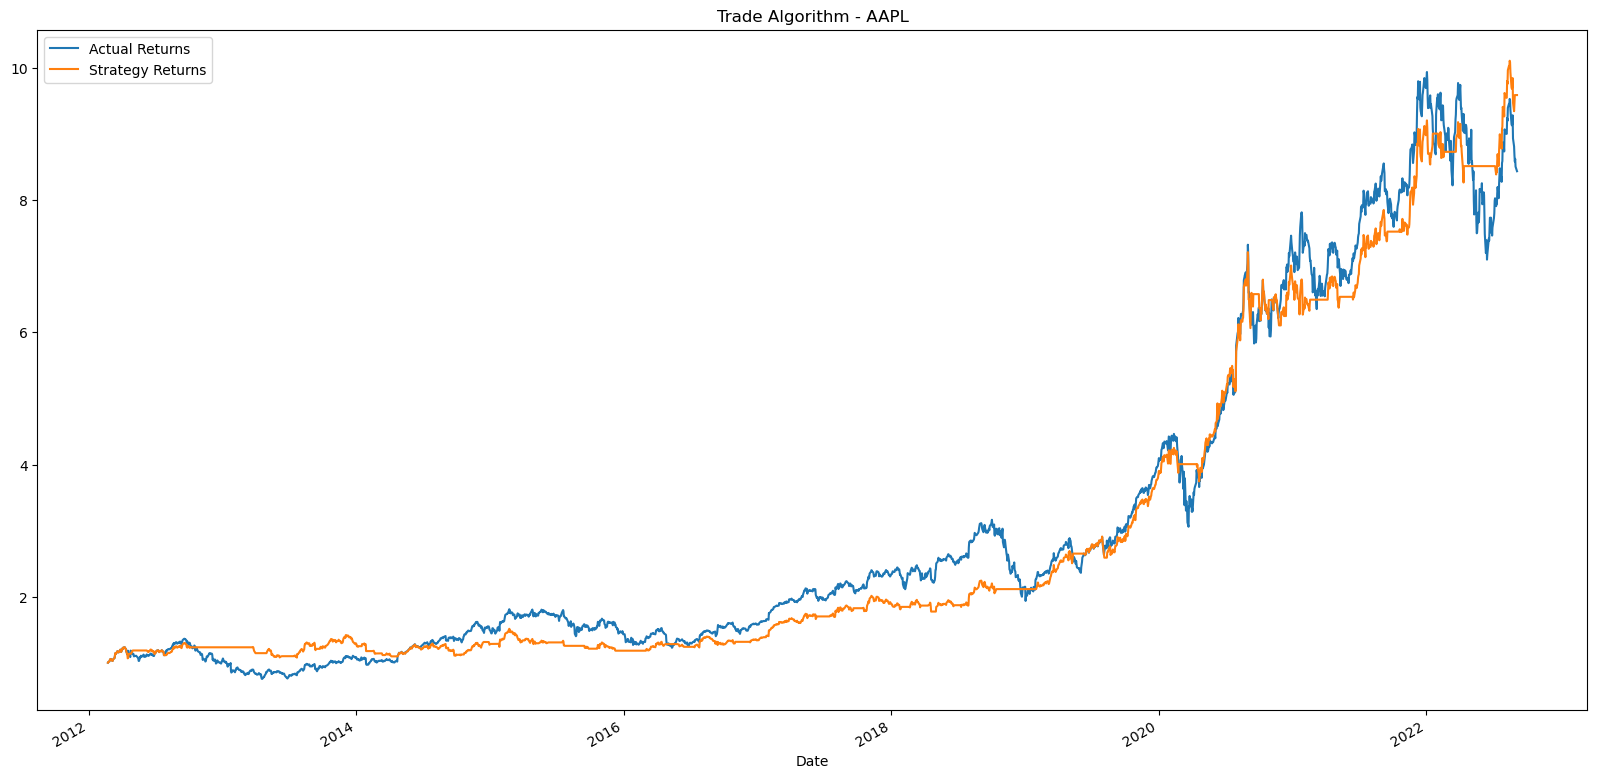

In [89]:
# Review cumulative return plot - Apple
(1 + aapl_technical_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="Trade Algorithm - AAPL")

<AxesSubplot:title={'center':'Trade Algorithm - MSFT'}, xlabel='Date'>

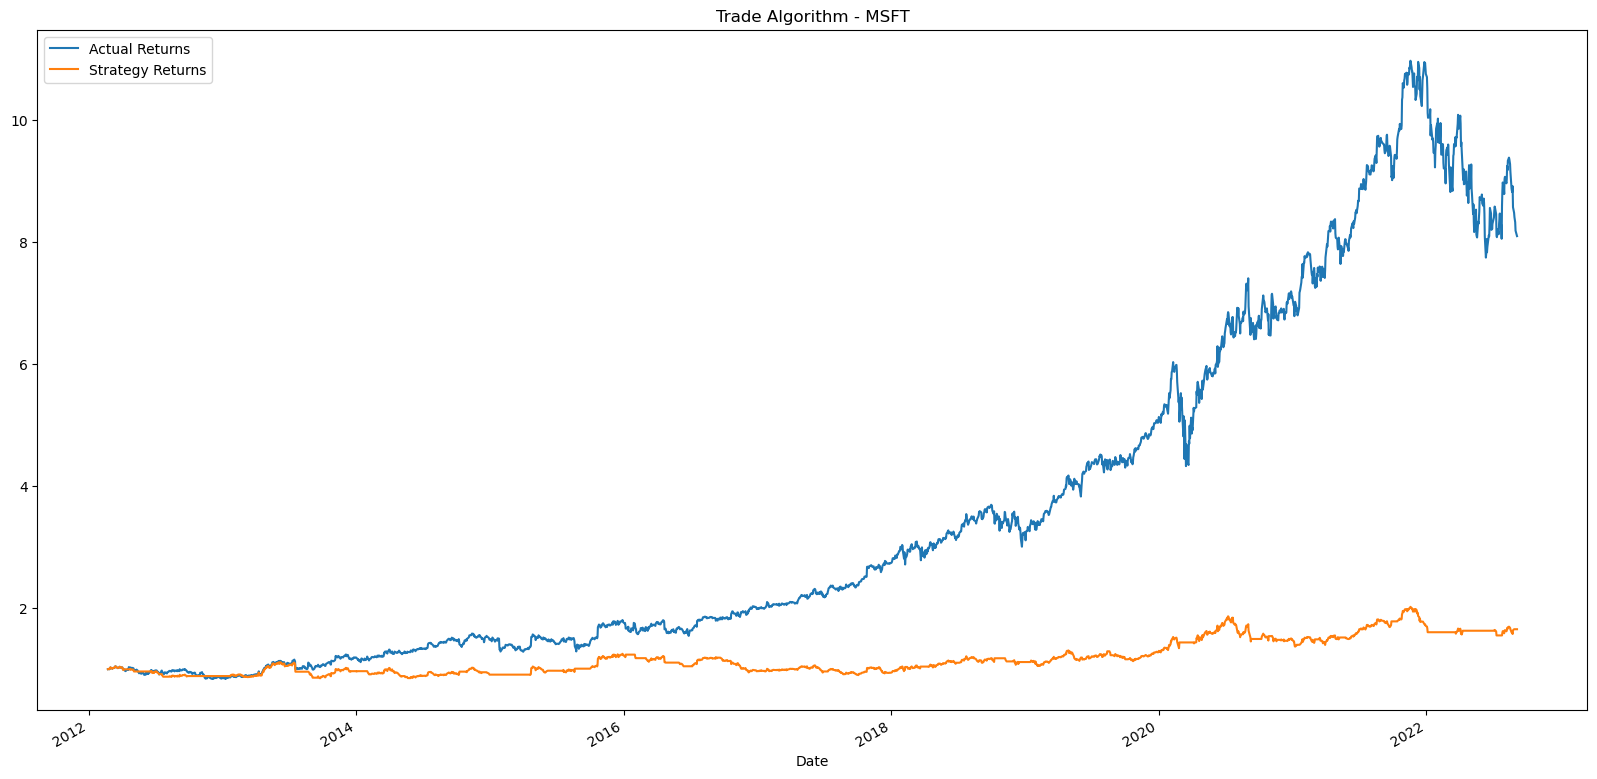

In [90]:
# Review cumulative return plot - Microsoft
(1 + msft_technical_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="Trade Algorithm - MSFT")

In [42]:
# Review resulting dataframe - Apple
aapl_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,RSI,MACD,MACD Signal,MACD Hist,Signals,Strategy Returns
Date,,,,,,,,,,,
2012-02-22,18.322857,-0.003516,17.996433,17.532235,16.639912,78.937712,0.867504,0.832217,0.035287,1.0,NaN
2012-02-23,18.442499,0.006530,18.107949,17.653604,16.764228,79.861265,0.866507,0.839075,0.027432,1.0,0.006530
2012-02-24,18.657499,0.011658,18.245337,17.787456,16.894799,81.436534,0.873002,0.845860,0.027142,1.0,0.011658
2012-02-27,18.777143,0.006413,18.378288,17.919415,17.024616,82.267768,0.877687,0.852226,0.025461,1.0,0.006413
2012-02-28,19.121786,0.018354,18.564163,18.079731,17.169248,84.430496,0.898848,0.861550,0.037298,1.0,0.018354
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,158.910004,-0.015305,164.483905,165.845999,163.460681,41.642421,1.895740,3.953608,-2.057868,-1.0,0.015305
2022-08-31,157.220001,-0.010635,162.667929,164.695866,163.030289,39.315121,1.070936,3.377073,-2.306137,0.0,0.010635
2022-09-01,157.960007,0.004707,161.490949,163.797751,162.680615,40.873353,0.471550,2.795969,-2.324419,0.0,0.000000


In [43]:
# Review resulting dataframe - Microsoft
msft_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,RSI,MACD,MACD Signal,MACD Hist,Signals,Strategy Returns
Date,,,,,,,,,,,
2012-02-22,31.270000,-0.005407,30.991866,30.598566,29.799234,70.349661,0.801376,0.812600,-0.011224,1.0,NaN
2012-02-23,31.370001,0.003198,31.086400,30.701424,29.907563,71.166132,0.794915,0.809063,-0.014148,1.0,0.003198
2012-02-24,31.480000,0.003507,31.184800,30.805234,30.016007,72.076974,0.789569,0.805165,-0.015595,1.0,0.003507
2012-02-27,31.350000,-0.004130,31.226100,30.877870,30.108006,69.291129,0.766012,0.797334,-0.031322,1.0,-0.004130
2012-02-28,31.870001,0.016587,31.387075,31.010154,30.229523,73.674277,0.780308,0.793929,-0.013621,1.0,0.016587
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,262.970001,-0.008521,271.699000,275.997926,275.842781,36.633382,-0.744901,2.793705,-3.538606,0.0,-0.000000
2022-08-31,261.470001,-0.005704,269.141751,274.060869,274.851555,35.536546,-1.795519,1.875860,-3.671379,0.0,-0.000000
2022-09-01,260.399994,-0.004092,266.956311,272.239419,273.854896,34.737551,-2.683547,0.963979,-3.647526,0.0,-0.000000


### Stock A Models - AAPL

#### Data Prep

In [44]:
# Add signals for when 1. Close is greater than 7 Day EMA, and 2. MACD Signal is greater than MACD. Also add target variable for when Actual Returns are positive or negative
aapl_technical_df["Close_EMA"] = np.where(aapl_technical_df["Close"] > aapl_technical_df["7 Day EMA"], 1.0, -1.0)

aapl_technical_df["MACD_Signal_MACD"] = np.where(aapl_technical_df["MACD Signal"] > aapl_technical_df["MACD"], 1.0, -1.0)

aapl_technical_df["Target"] = np.where(aapl_technical_df["Actual Returns"] > 0, 1.0, 0.0)

# Drop NaN values
aapl_technical_df = aapl_technical_df.dropna().copy()

# Review dataframe
aapl_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,RSI,MACD,MACD Signal,MACD Hist,Signals,Strategy Returns,Close_EMA,MACD_Signal_MACD,Target
Date,,,,,,,,,,,,,,
2012-02-23,18.442499,0.006530,18.107949,17.653604,16.764228,79.861265,0.866507,0.839075,0.027432,1.0,0.006530,1.0,-1.0,1.0
2012-02-24,18.657499,0.011658,18.245337,17.787456,16.894799,81.436534,0.873002,0.845860,0.027142,1.0,0.011658,1.0,-1.0,1.0
2012-02-27,18.777143,0.006413,18.378288,17.919415,17.024616,82.267768,0.877687,0.852226,0.025461,1.0,0.006413,1.0,-1.0,1.0
2012-02-28,19.121786,0.018354,18.564163,18.079731,17.169248,84.430496,0.898848,0.861550,0.037298,1.0,0.018354,1.0,-1.0,1.0
2012-02-29,19.372856,0.013130,18.766336,18.252147,17.321221,85.790178,0.925212,0.874282,0.050930,1.0,0.013130,1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,158.910004,-0.015305,164.483905,165.845999,163.460681,41.642421,1.895740,3.953608,-2.057868,-1.0,0.015305,-1.0,1.0,0.0
2022-08-31,157.220001,-0.010635,162.667929,164.695866,163.030289,39.315121,1.070936,3.377073,-2.306137,0.0,0.010635,-1.0,1.0,0.0
2022-09-01,157.960007,0.004707,161.490949,163.797751,162.680615,40.873353,0.471550,2.795969,-2.324419,0.0,0.000000,-1.0,1.0,1.0


In [45]:
# Create features data set X using RSI, MACD, and MACD Signals
aapl_X = aapl_technical_df[["RSI", "MACD Signal", "MACD"]]

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit scaler to X data
X_scaler = scaler.fit(aapl_X)

# Scale X data
aapl_X_scaled = X_scaler.transform(aapl_X)

# Turn scaled data into a dataframe
aapl_X_scaled_df = pd.DataFrame(aapl_X_scaled, index=aapl_X.index, columns=aapl_X.columns)

# Review new dataframe
aapl_X_scaled_df

,RSI,MACD Signal,MACD
Date,,,
2012-02-23,1.860957,0.318490,0.316644
2012-02-24,1.980122,0.323252,0.320928
2012-02-27,2.043002,0.327719,0.324017
2012-02-28,2.206606,0.334263,0.337974
2012-02-29,2.309462,0.343199,0.355363
...,...,...,...
2022-08-30,-1.030187,2.504254,0.995477
2022-08-31,-1.206241,2.099645,0.451475
2022-09-01,-1.088365,1.691829,0.056149


In [46]:
# Create target vector y
aapl_y = aapl_technical_df["Signals"]

# Review y data
aapl_y

Date
2012-02-23    1.0
2012-02-24    1.0
2012-02-27    1.0
2012-02-28    1.0
2012-02-29    1.0
             ... 
2022-08-30   -1.0
2022-08-31    0.0
2022-09-01    0.0
2022-09-02    0.0
2022-09-06    0.0
Name: Signals, Length: 2652, dtype: float64

In [47]:
# Create start and end dates for training
training_begin = aapl_technical_df.index.min()

training_end = aapl_technical_df.index.min() + DateOffset(months=6)

# Create X and y training and testing datasets
X_train = aapl_X_scaled_df.loc[training_begin:training_end]

y_train = aapl_y.loc[training_begin:training_end]

X_test = aapl_X_scaled_df.loc[training_end:]

y_test = aapl_y.loc[training_end:]

In [48]:
# Verify X dataframes
display(X_train.head())

display(X_test.head())

,RSI,MACD Signal,MACD
Date,,,
2012-02-23,1.860957,0.318490,0.316644
2012-02-24,1.980122,0.323252,0.320928
2012-02-27,2.043002,0.327719,0.324017
2012-02-28,2.206606,0.334263,0.337974
2012-02-29,2.309462,0.343199,0.355363


,RSI,MACD Signal,MACD
Date,,,
2012-08-23,1.106097,0.049659,0.137088
2012-08-24,1.120951,0.070415,0.143437
2012-08-27,1.413256,0.092096,0.167286
2012-08-28,1.358846,0.112041,0.179507
2012-08-29,1.272519,0.128450,0.181633


In [49]:
# Verify y data
display(y_train.head())

display(y_test.head())

Date
2012-02-23    1.0
2012-02-24    1.0
2012-02-27    1.0
2012-02-28    1.0
2012-02-29    1.0
Name: Signals, dtype: float64

Date
2012-08-23    1.0
2012-08-24    1.0
2012-08-27    1.0
2012-08-28    1.0
2012-08-29    1.0
Name: Signals, dtype: float64

In [50]:
# Define a function that runs several different models and evaluates each one to determine the most ideal models for data used
def model_selection(X, y):
    seed = 2

    models = []

    models.append(("GaussianNB", GaussianNB()))

    models.append(("SVM", svm.SVC(random_state=seed)))

    models.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))

    models.append(("LogisticRegression", LogisticRegression(random_state=seed)))

    models.append(("DecisionTreeRegressor", DecisionTreeRegressor(random_state=seed)))

    models.append(("KNeighborsClassifier", KNeighborsClassifier()))

    models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))

    models.append(("RandomForestClassifier", RandomForestClassifier()))

    models.append(("ExtraTreesClassifier", ExtraTreesClassifier(random_state=seed)))

    models.append(("AdaBoostClassifier", AdaBoostClassifier(DecisionTreeClassifier(random_state=seed), random_state=seed, learning_rate=0.1)))

    models.append(("GradientBoostingClassifier", GradientBoostingClassifier(random_state=seed)))

    models.append(("MLPClassifier", MLPClassifier(random_state=seed, max_iter=2000)))

# Evaluate each model in turn
    results = []
    names = []
    scoring = "accuracy"
    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed) 
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %0.3f (%0.3f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    fig = plt.figure()
    fig.suptitle("Algorithm Comparison")
    ax = fig.add_subplot()
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.xticks(rotation=90)
    plt.show()
    return results, names

GaussianNB: 0.900 (0.011)
SVM: 0.925 (0.016)
LinearDiscriminantAnalysis: 0.888 (0.020)
LogisticRegression: 0.929 (0.013)
DecisionTreeRegressor: 0.935 (0.013)
KNeighborsClassifier: 0.936 (0.008)
DecisionTreeClassifier: 0.942 (0.015)
RandomForestClassifier: 0.954 (0.012)
ExtraTreesClassifier: 0.960 (0.011)
AdaBoostClassifier: 0.940 (0.017)
GradientBoostingClassifier: 0.955 (0.015)
MLPClassifier: 0.982 (0.007)


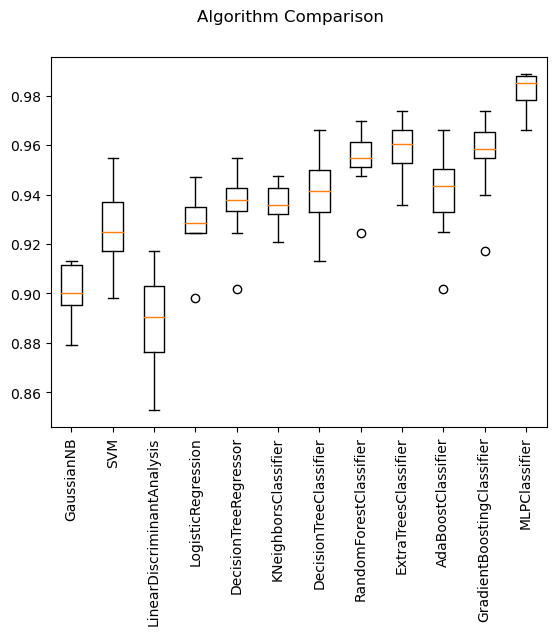

([array([0.89849624, 0.88345865, 0.89811321, 0.91320755, 0.89433962,
         0.90566038, 0.91320755, 0.91320755, 0.90188679, 0.87924528]),
  array([0.92857143, 0.92105263, 0.95471698, 0.94339623, 0.91698113,
         0.92830189, 0.93962264, 0.90566038, 0.91698113, 0.89811321]),
  array([0.91353383, 0.86466165, 0.90566038, 0.91698113, 0.88679245,
         0.89433962, 0.87924528, 0.89433962, 0.8754717 , 0.85283019]),
  array([0.92857143, 0.92481203, 0.94716981, 0.94716981, 0.9245283 ,
         0.92830189, 0.93584906, 0.93207547, 0.9245283 , 0.89811321]),
  array([0.93233083, 0.93984962, 0.94339623, 0.93584906, 0.95471698,
         0.93584906, 0.9245283 , 0.93962264, 0.94339623, 0.90188679]),
  array([0.94736842, 0.93233083, 0.93584906, 0.94716981, 0.93584906,
         0.93207547, 0.94339623, 0.92830189, 0.93962264, 0.92075472]),
  array([0.94736842, 0.92857143, 0.94339623, 0.95849057, 0.93584906,
         0.9509434 , 0.93207547, 0.96603774, 0.93962264, 0.91320755]),
  array([0.96240602,

In [51]:
# Run model selection function using scaled X and y data
model_selection(aapl_X_scaled_df, aapl_y)

#### Model A - Multi-Layer Perceptron (MLP) Classifier

In [52]:
# Define MLPClassifier model with random state of 1 and max iterations of 2000
mlp_model = MLPClassifier(
    max_iter=2000, 
    random_state=1
)

# Fit MLP model to training data
mlp_model = mlp_model.fit(X_train, y_train)

# Predict using testing data
mlp_pred = mlp_model.predict(X_test)

In [53]:
# Create classification report with results
mlp_testing_report = classification_report(y_test, mlp_pred)

# Print classification report
print(mlp_testing_report)

              precision    recall  f1-score   support

        -1.0       0.71      0.82      0.76       149
         0.0       0.98      0.98      0.98       886
         1.0       0.98      0.97      0.98      1490

    accuracy                           0.96      2525
   macro avg       0.89      0.92      0.91      2525
weighted avg       0.97      0.96      0.97      2525



In [54]:
# Create predictions dataframe
mlp_predictions_df = pd.DataFrame(index=X_test.index)

# Create Predicted column using predictions
mlp_predictions_df["Predicted"] = mlp_pred

# Create Actual Returns column based on original dataframe returns column
mlp_predictions_df["Actual Returns"] = aapl_technical_df["Actual Returns"]

# Create Strategy Returns column
mlp_predictions_df["Strategy Returns"] = (mlp_predictions_df["Actual Returns"] * mlp_predictions_df["Predicted"].shift())

# Review dataframe with .head()
mlp_predictions_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-08-23,1.0,-0.009329,NaN
2012-08-24,1.0,0.000890,0.000890
2012-08-27,1.0,0.018787,0.018787
2012-08-28,1.0,-0.001302,-0.001302
2012-08-29,1.0,-0.001971,-0.001971


In [55]:
# Calculate cumulative returns for Actual Returns and Strategy Returns columns
(1 + mlp_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-08-23,0.990671,NaN
2012-08-24,0.991553,1.000890
2012-08-27,1.010181,1.019694
2012-08-28,1.008866,1.018366
2012-08-29,1.006877,1.016359
...,...,...
2022-08-30,6.652235,7.315025
2022-08-31,6.581488,7.392820
2022-09-01,6.612466,7.358023


<AxesSubplot:title={'center':'MLP Classifier - AAPL'}, xlabel='Date'>

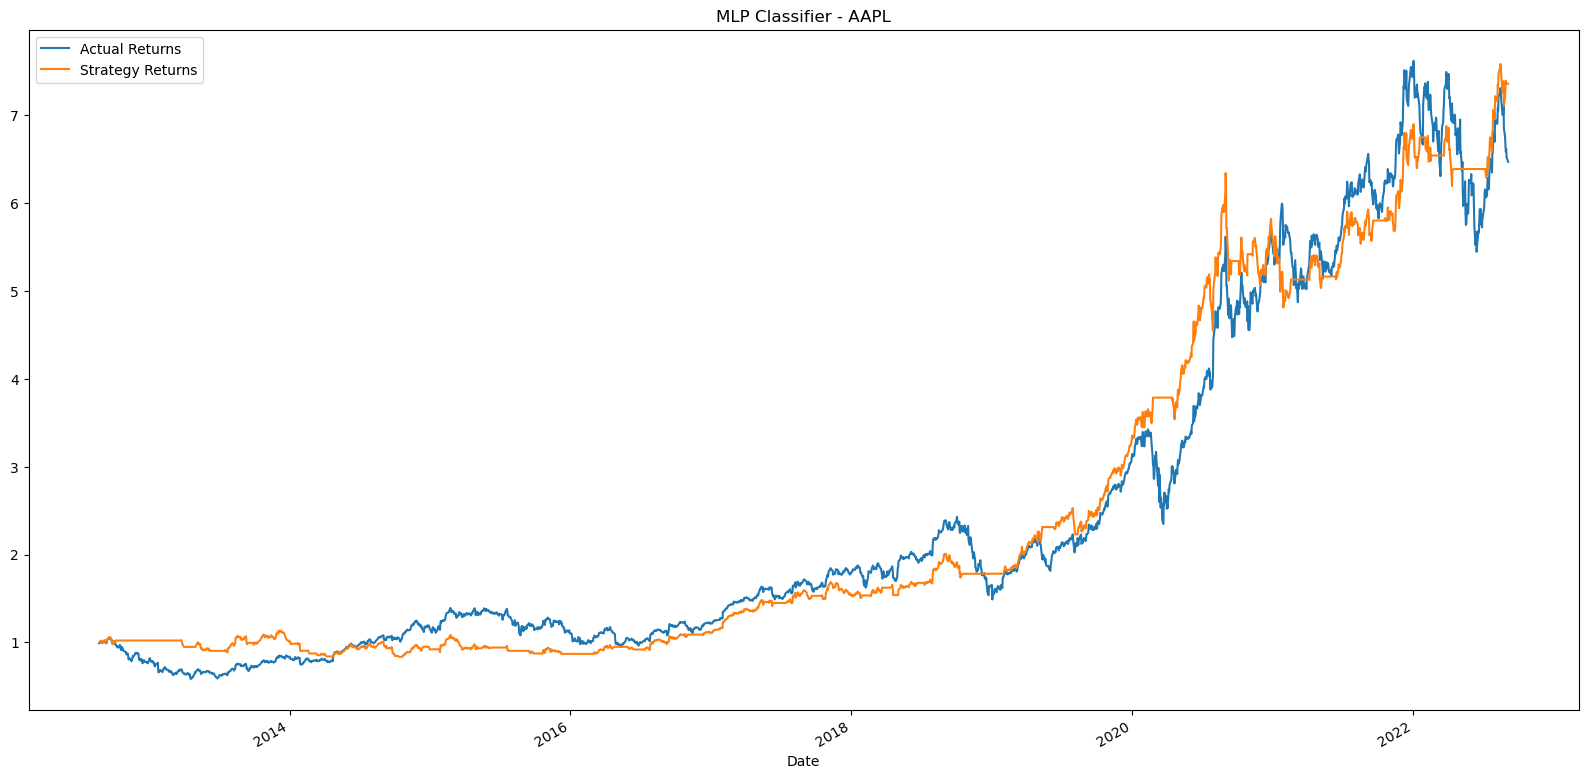

In [56]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + mlp_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="MLP Classifier - AAPL")

#### Model B - Extra Trees Classifier

In [57]:
# Define ExtraTreesClassifier model with random state of 1
etc_model = ExtraTreesClassifier(
    random_state=1
)

# Fit ETC model to training data
etc_model = etc_model.fit(X_train, y_train)

# Predict using testing data
etc_pred = etc_model.predict(X_test)

In [58]:
# Create classification report with results
etc_testing_report = classification_report(y_test, etc_pred)

# Print classification report
print(etc_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.48      0.46       149
         0.0       0.93      0.95      0.94       886
         1.0       0.94      0.92      0.93      1490

    accuracy                           0.90      2525
   macro avg       0.77      0.78      0.78      2525
weighted avg       0.91      0.90      0.91      2525



In [59]:
# Create predictions dataframe
etc_predictions_df = pd.DataFrame(index=X_test.index)

# Create Predicted column using predictions
etc_predictions_df["Predicted"] = etc_pred

# Create Actual Returns column based on original dataframe returns column
etc_predictions_df["Actual Returns"] = aapl_technical_df["Actual Returns"]

# Create Strategy Returns column
etc_predictions_df["Strategy Returns"] = (etc_predictions_df["Actual Returns"] * etc_predictions_df["Predicted"].shift())

# Review dataframe with .head()
etc_predictions_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-08-23,1.0,-0.009329,NaN
2012-08-24,1.0,0.000890,0.000890
2012-08-27,1.0,0.018787,0.018787
2012-08-28,1.0,-0.001302,-0.001302
2012-08-29,1.0,-0.001971,-0.001971


In [60]:
# Calculate cumulative returns for Actual Returns and Strategy Returns columns
(1 + etc_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-08-23,0.990671,NaN
2012-08-24,0.991553,1.000890
2012-08-27,1.010181,1.019694
2012-08-28,1.008866,1.018366
2012-08-29,1.006877,1.016359
...,...,...
2022-08-30,6.652235,5.701832
2022-08-31,6.581488,5.641193
2022-09-01,6.612466,5.667746


<AxesSubplot:title={'center':'ETC Classifier - AAPL'}, xlabel='Date'>

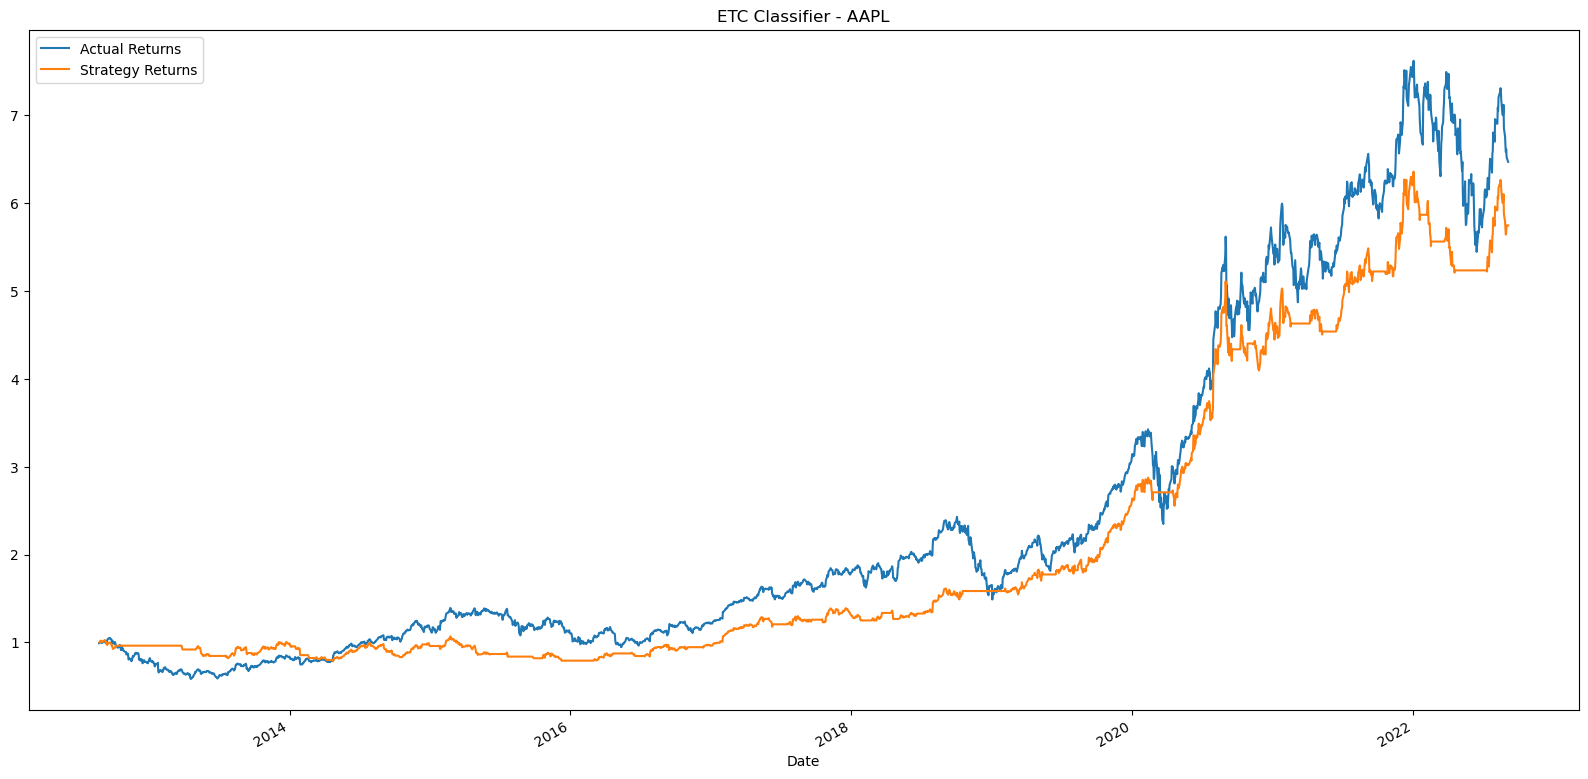

In [61]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + etc_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="ETC Classifier - AAPL")

#### Model C - Gradient Boosting Classifier

In [62]:
# Define GradientBoostingClassifier model with random state of 1
gbc_model = GradientBoostingClassifier(
    random_state=1
)

# Fit GBC model to training data
gbc_model = gbc_model.fit(X_train, y_train)

# Predict using testing data
gbc_pred = gbc_model.predict(X_test)

In [63]:
# Create classification report with results
gbc_testing_report = classification_report(y_test, gbc_pred)

# Print classification report
print(gbc_testing_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.47      0.51       149
         0.0       0.93      0.97      0.95       886
         1.0       0.95      0.94      0.94      1490

    accuracy                           0.92      2525
   macro avg       0.82      0.79      0.80      2525
weighted avg       0.92      0.92      0.92      2525



In [64]:
# Create predictions dataframe
gbc_predictions_df = pd.DataFrame(index=X_test.index)

# Create Predicted column using predictions
gbc_predictions_df["Predicted"] = gbc_pred

# Create Actual Returns column based on original dataframe returns column
gbc_predictions_df["Actual Returns"] = aapl_technical_df["Actual Returns"]

# Create Strategy Returns column
gbc_predictions_df["Strategy Returns"] = (gbc_predictions_df["Actual Returns"] * gbc_predictions_df["Predicted"].shift())

# Review dataframe with .head()
gbc_predictions_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-08-23,1.0,-0.009329,NaN
2012-08-24,1.0,0.000890,0.000890
2012-08-27,1.0,0.018787,0.018787
2012-08-28,1.0,-0.001302,-0.001302
2012-08-29,1.0,-0.001971,-0.001971


In [65]:
# Calculate cumulative returns for Actual Returns and Strategy Returns columns
(1 + gbc_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-08-23,0.990671,NaN
2012-08-24,0.991553,1.000890
2012-08-27,1.010181,1.019694
2012-08-28,1.008866,1.018366
2012-08-29,1.006877,1.016359
...,...,...
2022-08-30,6.652235,3.856095
2022-08-31,6.581488,3.815085
2022-09-01,6.612466,3.833042


<AxesSubplot:title={'center':'GBC Classifier - AAPL'}, xlabel='Date'>

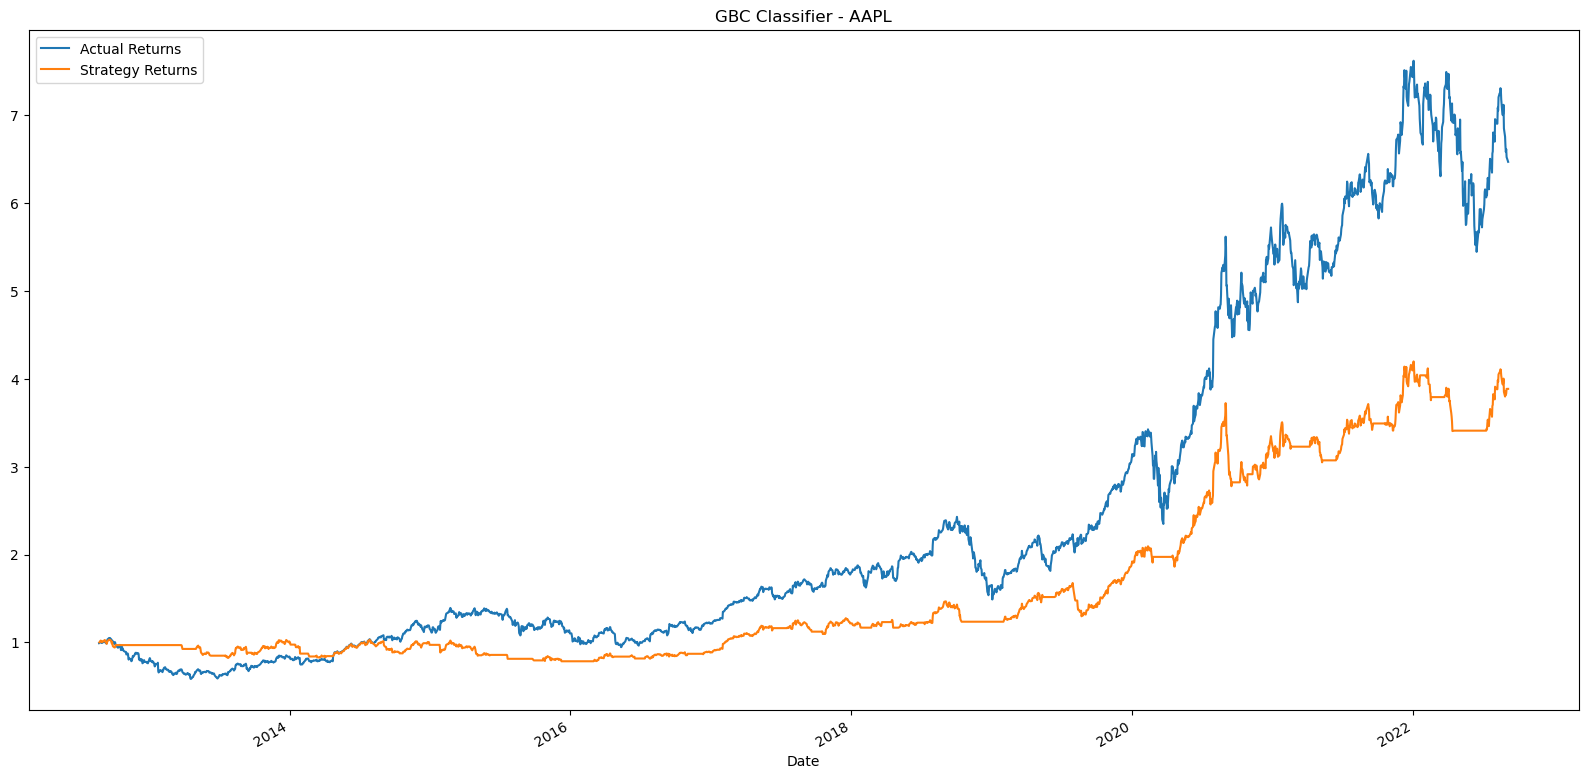

In [66]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + gbc_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="GBC Classifier - AAPL")

### Stock B Models - MSFT

#### Data Prep

In [67]:
# Add signals for when 1. Close is greater than 7 Day EMA, and 2. MACD Signal is greater than MACD. Also add target variable for when Actual Returns are positive or negative
msft_technical_df["Close_EMA"] = np.where(msft_technical_df["Close"] > msft_technical_df["7 Day EMA"], 1.0, -1.0)

msft_technical_df["MACD_Signal_MACD"] = np.where(msft_technical_df["MACD Signal"] > msft_technical_df["MACD"], 1.0, -1.0)

msft_technical_df["Target"] = np.where(msft_technical_df["Actual Returns"] > 0, 1.0, 0.0)

# Drop NaN values
msft_technical_df = msft_technical_df.dropna().copy()

# Review dataframe
msft_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,RSI,MACD,MACD Signal,MACD Hist,Signals,Strategy Returns,Close_EMA,MACD_Signal_MACD,Target
Date,,,,,,,,,,,,,,
2012-02-23,31.370001,0.003198,31.086400,30.701424,29.907563,71.166132,0.794915,0.809063,-0.014148,1.0,0.003198,1.0,1.0,1.0
2012-02-24,31.480000,0.003507,31.184800,30.805234,30.016007,72.076974,0.789569,0.805165,-0.015595,1.0,0.003507,1.0,1.0,1.0
2012-02-27,31.350000,-0.004130,31.226100,30.877870,30.108006,69.291129,0.766012,0.797334,-0.031322,1.0,-0.004130,1.0,1.0,0.0
2012-02-28,31.870001,0.016587,31.387075,31.010154,30.229523,73.674277,0.780308,0.793929,-0.013621,1.0,0.016587,1.0,1.0,1.0
2012-02-29,31.740000,-0.004079,31.475306,31.107467,30.333694,70.947881,0.772246,0.789592,-0.017346,1.0,-0.004079,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,262.970001,-0.008521,271.699000,275.997926,275.842781,36.633382,-0.744901,2.793705,-3.538606,0.0,-0.000000,-1.0,1.0,0.0
2022-08-31,261.470001,-0.005704,269.141751,274.060869,274.851555,35.536546,-1.795519,1.875860,-3.671379,0.0,-0.000000,-1.0,1.0,0.0
2022-09-01,260.399994,-0.004092,266.956311,272.239419,273.854896,34.737551,-2.683547,0.963979,-3.647526,0.0,-0.000000,-1.0,1.0,0.0


In [68]:
# Create features data set X using RSI, MACD, and MACD Signals
msft_X = msft_technical_df[["RSI", "MACD Signal", "MACD"]]

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit scaler to X data
X_scaler = scaler.fit(msft_X)

# Scale X data
msft_X_scaled = X_scaler.transform(msft_X)

# Turn scaled data into a dataframe
msft_X_scaled_df = pd.DataFrame(msft_X_scaled, index=msft_X.index, columns=msft_X.columns)

# Review new dataframe
msft_X_scaled_df

,RSI,MACD Signal,MACD
Date,,,
2012-02-23,1.467241,0.077899,0.066842
2012-02-24,1.550922,0.075980,0.064408
2012-02-27,1.294978,0.072128,0.053680
2012-02-28,1.697672,0.070453,0.060190
2012-02-29,1.447189,0.068319,0.056519
...,...,...,...
2022-08-30,-1.705389,1.054343,-0.634388
2022-08-31,-1.806159,0.602763,-1.112839
2022-09-01,-1.879565,0.154117,-1.517246


In [69]:
# Create target vector y
msft_y = msft_technical_df["Signals"]

# Review y data
msft_y

Date
2012-02-23    1.0
2012-02-24    1.0
2012-02-27    1.0
2012-02-28    1.0
2012-02-29    1.0
             ... 
2022-08-30    0.0
2022-08-31    0.0
2022-09-01    0.0
2022-09-02    0.0
2022-09-06    0.0
Name: Signals, Length: 2652, dtype: float64

In [70]:
# Create start and end dates for model test
begin = msft_technical_df.index.min()

end = msft_technical_df.index.max()

# Create X and y for model
X_msft = msft_X_scaled_df.loc[begin:end]

y_msft = msft_y.loc[begin:end]

In [71]:
# Verify X dataframe
X_msft.head()

,RSI,MACD Signal,MACD
Date,,,
2012-02-23,1.467241,0.077899,0.066842
2012-02-24,1.550922,0.075980,0.064408
2012-02-27,1.294978,0.072128,0.053680
2012-02-28,1.697672,0.070453,0.060190
2012-02-29,1.447189,0.068319,0.056519


In [72]:
# Verify y data
y_msft[:5]

Date
2012-02-23    1.0
2012-02-24    1.0
2012-02-27    1.0
2012-02-28    1.0
2012-02-29    1.0
Name: Signals, dtype: float64

#### Model A - Multi-Layer Perceptron (MLP) Classifier

In [73]:
# Predict using Microsoft data and Apple model
mlp_pred_msft = mlp_model.predict(X_msft)

In [74]:
# Create classification report with results
mlp_testing_report_msft = classification_report(y_msft, mlp_pred_msft)

# Print classification report
print(mlp_testing_report_msft)

              precision    recall  f1-score   support

        -1.0       0.65      0.72      0.68       179
         0.0       0.90      1.00      0.95       787
         1.0       0.99      0.93      0.96      1686

    accuracy                           0.94      2652
   macro avg       0.85      0.88      0.86      2652
weighted avg       0.94      0.94      0.94      2652



In [75]:
# Create predictions dataframe
mlp_predictions_msft_df = pd.DataFrame(index=X_msft.index)

# Create Predicted column using predictions
mlp_predictions_msft_df["Predicted"] = mlp_pred_msft

# Create Actual Returns column based on original dataframe returns column
mlp_predictions_msft_df["Actual Returns"] = msft_technical_df["Actual Returns"]

# Create Strategy Returns column
mlp_predictions_msft_df["Strategy Returns"] = (mlp_predictions_msft_df["Actual Returns"] * mlp_predictions_msft_df["Predicted"].shift())

# Review dataframe with .head()
mlp_predictions_msft_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-02-23,1.0,0.003198,NaN
2012-02-24,1.0,0.003507,0.003507
2012-02-27,1.0,-0.004130,-0.004130
2012-02-28,1.0,0.016587,0.016587
2012-02-29,1.0,-0.004079,-0.004079


In [76]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + mlp_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-02-23,1.003198,NaN
2012-02-24,1.006716,1.003507
2012-02-27,1.002558,0.999362
2012-02-28,1.019188,1.015939
2012-02-29,1.015030,1.011795
...,...,...
2022-08-30,8.409658,2.006878
2022-08-31,8.361689,2.006878
2022-09-01,8.327470,2.006878


<AxesSubplot:title={'center':'MLP Classifier - MSFT'}, xlabel='Date'>

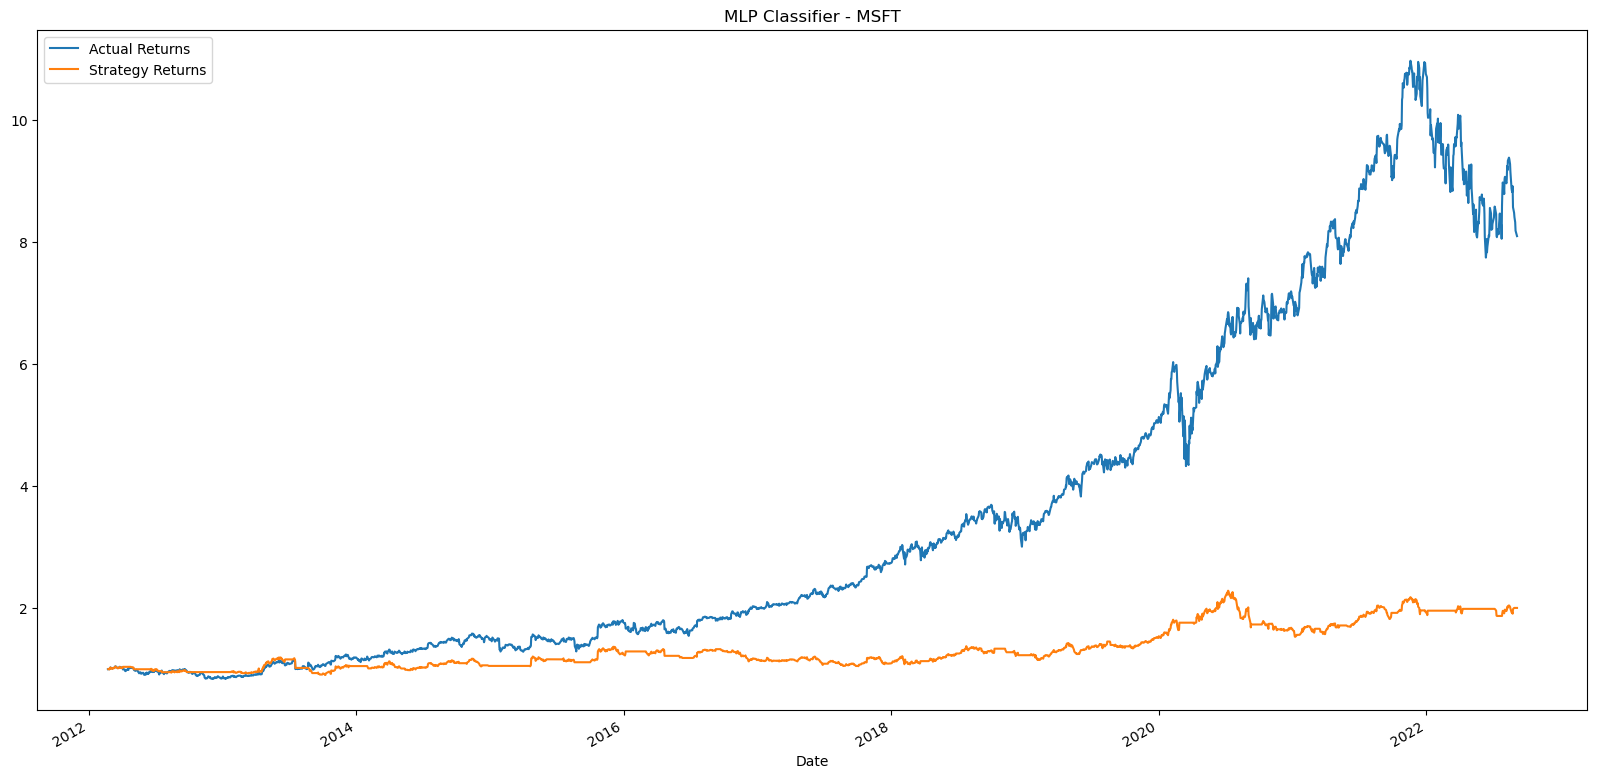

In [77]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + mlp_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="MLP Classifier - MSFT")

#### Model B - Extra Trees Classifier

In [78]:
# Predict using Microsoft data and Apple model
etc_pred_msft = etc_model.predict(X_msft)

In [79]:
# Create classification report with results
etc_testing_report_msft = classification_report(y_msft, etc_pred_msft)

# Print classification report
print(etc_testing_report_msft)

              precision    recall  f1-score   support

        -1.0       0.38      0.36      0.37       179
         0.0       0.88      0.98      0.93       787
         1.0       0.95      0.90      0.92      1686

    accuracy                           0.89      2652
   macro avg       0.74      0.75      0.74      2652
weighted avg       0.89      0.89      0.89      2652



In [80]:
# Create predictions dataframe
etc_predictions_msft_df = pd.DataFrame(index=X_msft.index)

# Create Predicted column using predictions
etc_predictions_msft_df["Predicted"] = etc_pred_msft

# Create Actual Returns column based on original dataframe returns column
etc_predictions_msft_df["Actual Returns"] = msft_technical_df["Actual Returns"]

# Create Strategy Returns column
etc_predictions_msft_df["Strategy Returns"] = (etc_predictions_msft_df["Actual Returns"] * etc_predictions_msft_df["Predicted"].shift())

# Review dataframe with .head()
etc_predictions_msft_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-02-23,1.0,0.003198,NaN
2012-02-24,1.0,0.003507,0.003507
2012-02-27,1.0,-0.004130,-0.004130
2012-02-28,1.0,0.016587,0.016587
2012-02-29,1.0,-0.004079,-0.004079


In [81]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + etc_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-02-23,1.003198,NaN
2012-02-24,1.006716,1.003507
2012-02-27,1.002558,0.999362
2012-02-28,1.019188,1.015939
2012-02-29,1.015030,1.011795
...,...,...
2022-08-30,8.409658,1.135027
2022-08-31,8.361689,1.135027
2022-09-01,8.327470,1.135027


<AxesSubplot:title={'center':'ETC Classifier - MSFT'}, xlabel='Date'>

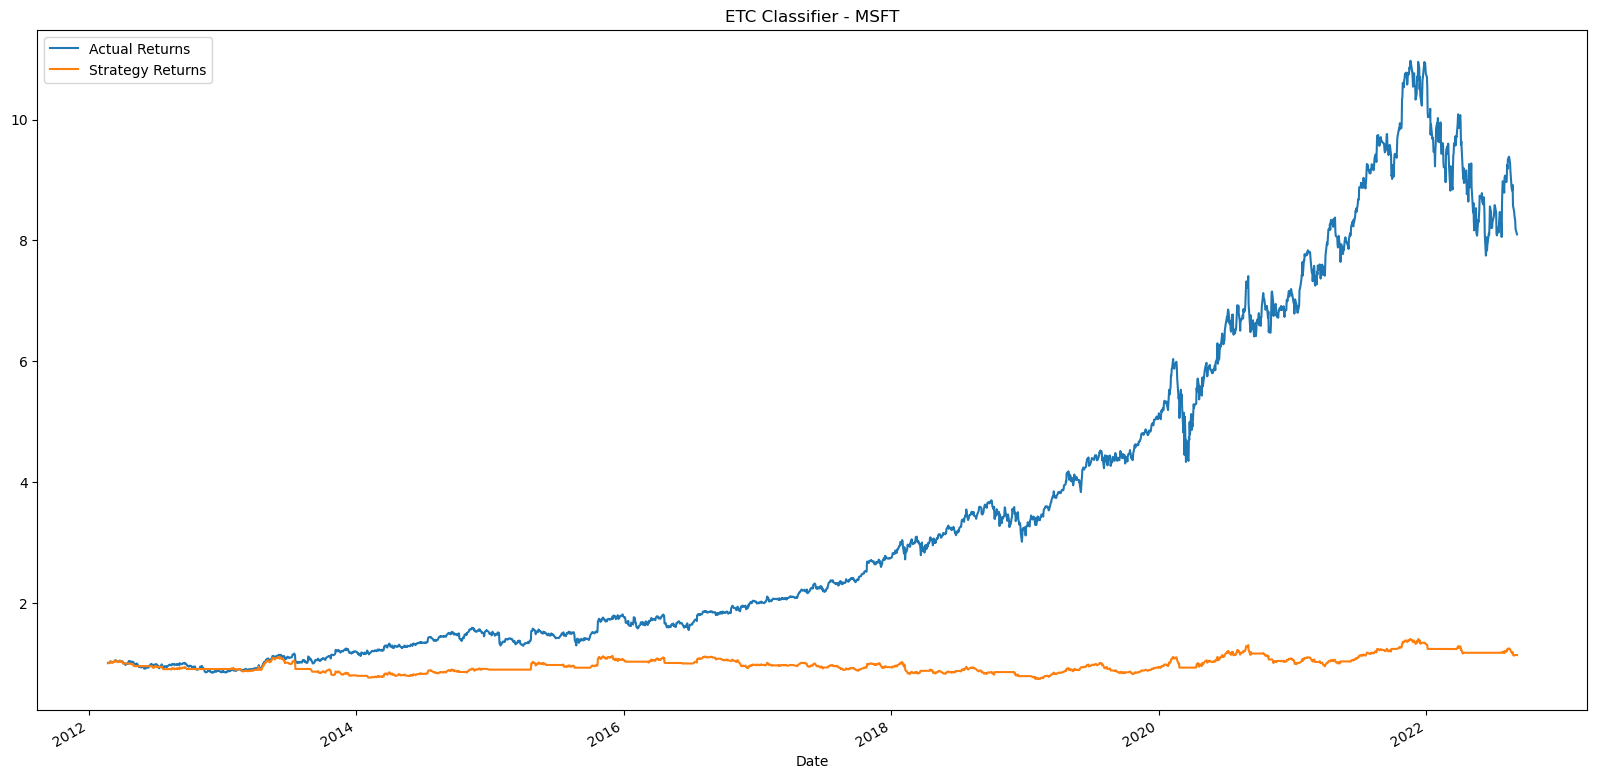

In [82]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + etc_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="ETC Classifier - MSFT")

#### Model C - Gradient Boosting Classifier

In [83]:
# Predict using Microsoft data and Apple model
gbc_pred_msft = gbc_model.predict(X_msft)

In [84]:
# Create classification report with results
gbc_testing_report_msft = classification_report(y_msft, gbc_pred_msft)

# Print classification report
print(gbc_testing_report_msft)

              precision    recall  f1-score   support

        -1.0       0.46      0.37      0.41       179
         0.0       0.85      0.98      0.91       787
         1.0       0.96      0.91      0.93      1686

    accuracy                           0.90      2652
   macro avg       0.76      0.76      0.75      2652
weighted avg       0.89      0.90      0.89      2652



In [85]:
# Create predictions dataframe
gbc_predictions_msft_df = pd.DataFrame(index=X_msft.index)

# Create Predicted column using predictions
gbc_predictions_msft_df["Predicted"] = gbc_pred_msft

# Create Actual Returns column based on original dataframe returns column
gbc_predictions_msft_df["Actual Returns"] = msft_technical_df["Actual Returns"]

# Create Strategy Returns column
gbc_predictions_msft_df["Strategy Returns"] = (gbc_predictions_msft_df["Actual Returns"] * gbc_predictions_msft_df["Predicted"].shift())

# Review dataframe with .head()
gbc_predictions_msft_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2012-02-23,1.0,0.003198,NaN
2012-02-24,1.0,0.003507,0.003507
2012-02-27,1.0,-0.004130,-0.004130
2012-02-28,1.0,0.016587,0.016587
2012-02-29,1.0,-0.004079,-0.004079


In [86]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + gbc_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod()

,Actual Returns,Strategy Returns
Date,,
2012-02-23,1.003198,NaN
2012-02-24,1.006716,1.003507
2012-02-27,1.002558,0.999362
2012-02-28,1.019188,1.015939
2012-02-29,1.015030,1.011795
...,...,...
2022-08-30,8.409658,1.367767
2022-08-31,8.361689,1.367767
2022-09-01,8.327470,1.367767


<AxesSubplot:title={'center':'GBC Classifier - MSFT'}, xlabel='Date'>

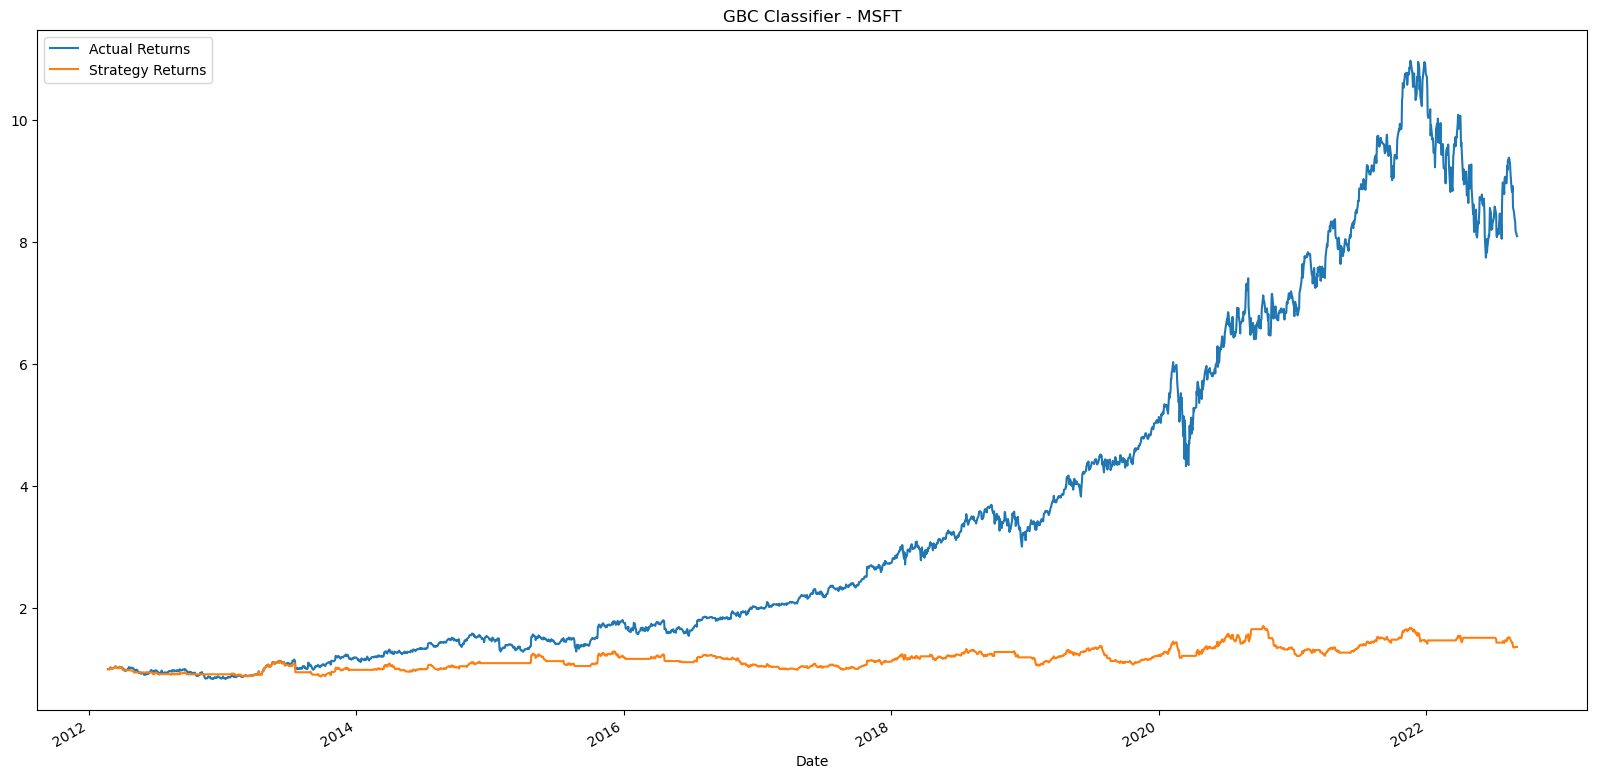

In [87]:
# Plot cumulative returns for Actual Returns and Strategy Returns columns
(1 + gbc_predictions_msft_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(20, 10), title="GBC Classifier - MSFT")